In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

In [4]:
def SW_gradSW(u,v,Teta):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    
    nbProj = Teta.shape[0]
    
    SW = 0
    gradSW = np.zeros((N,M,d))
    
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        
        for j in range(N*M):
                gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    SW = SW/nbProj
    
    return SW, gradSW

In [5]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out 
    
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

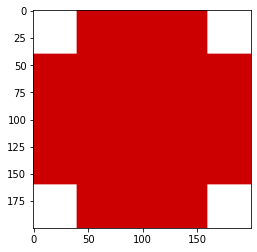

In [122]:
I1 = plt.imread('../data/ocean.jpg')
I2 = plt.imread('../data/redcross.png')
#Xtrue = I1[200:400, 450:750, :]/255
Xtrue = I2[200:400, 200:400, 0:3]#/255
plt.imshow(Xtrue)

In [123]:
Xtrue[100,100]

array([0.8, 0. , 0. ], dtype=float32)

In [124]:
nbPixel = Xtrue.shape[0]*Xtrue.shape[1]

r = np.random.RandomState(10)
print(r)
nbChgm = int(nbPixel/50)
idChgmI = r.randint(Xtrue.shape[0], size=(nbChgm,)) #1000 nombres aléatoires entre 0 et X1.shape --> 72000
idChgmJ = r.randint(Xtrue.shape[1], size=(nbChgm,)) #1000 nombres aléatoires entre 0 et X1.shape --> 72000

Xtrue_delayed = np.copy(Xtrue)
for i in range(nbChgm):
    change = r.rand(3,3)
    idI = idChgmI[i]
    idJ = idChgmJ[i]
    if(idI >= 2 and idJ >= 2 and idI<Xtrue_delayed.shape[0]-2 and idJ<Xtrue_delayed.shape[1]-2):
        for j in range(Xtrue_delayed.shape[2]):
            Xtrue_delayed[idI-1:idI+2,idJ-1:idJ+2,j] = change
            

RandomState(MT19937)


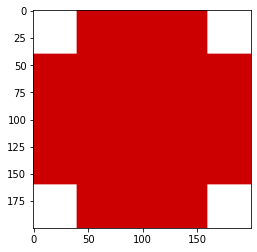

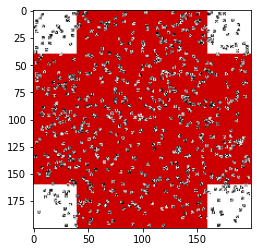

In [125]:
plt.figure()
plt.imshow(Xtrue)
plt.figure()
plt.imshow(Xtrue_delayed)

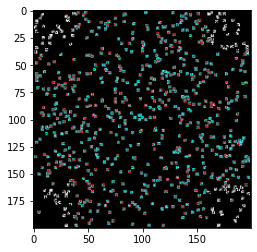

In [126]:
DeltaX_true = np.abs(Xtrue_delayed-Xtrue)
plt.imshow(DeltaX_true)

In [127]:
L_H = spatial_degradation(Xtrue, 2, 0)
L_M = spectrale_degradation(Xtrue_delayed, 1, 3, 0)

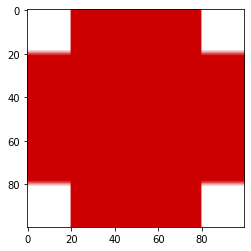

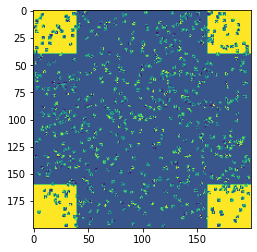

In [128]:
plt.figure()
plt.imshow(L_H)
plt.figure()
plt.imshow(L_M)

In [129]:
d_H = L_H.shape[2]
random_state = np.random.RandomState(None)
Teta_H = random_state.normal(0., 1., [10, d_H])
norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
Teta_H = Teta_H / norm_H

d_M = L_M.shape[2]
random_state = np.random.RandomState(None)
Teta_M = random_state.normal(0., 1., [10, d_M])
norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
Teta_M = Teta_M / norm_M


ck = 1/0.001
dk = 1/0.001

In [218]:
def prox1(X, Xbarre, Lbd, c_k):
    return (1/(2*Lbd+c_k))*(c_k*X + 2*Xbarre)
    
def prox2(X, mu, d_k):
    return (1/(2*mu +d_k))*d_k*X

In [219]:
def descente_detection(L_H, L_M, K_ech, b_low, b_high, Lbd, mu, gamma1, gamma2, nbProj):
    Xbarre = reech_interp(L_H, K_ech)
    #X = reech_interp(L_H, K_ech)
    X = np.zeros(Xbarre.shape)
    Delta_X = np.zeros(X.shape)
    
    Xbarre = reech_interp(L_H, K_ech)
    
    ck = 1/gamma1
    dk = 1/gamma2
    
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M


    SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M - spectrale_degradation(Delta_X, b_low, b_high, 0), Teta_M)
    
    L2 = np.linalg.norm(X-reech_interp(L_H, 2))**2
    L2Delta = np.linalg.norm(Delta_X)**2
    
    Fct = [SW1 + SW2 + Lbd*L2 + mu*L2Delta]    
    print( 'iter = ', 0 ,  "fonction = ", Fct[0])
    
    # Calcul première it de prox
    descente_X = X - (1/ck)*(spatial_degradation(Gradient1, K_ech, 1) + spectrale_degradation(Gradient2, b_low, b_high, 1))
    X = prox1(descente_X, Xbarre, Lbd, ck)
    #X = descente_X
    
    # Calcul deuxième it de prox
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X + Delta_X, b_low, b_high, 0), L_M, Teta_M)
    
    descente_DeltaX = Delta_X - (1/dk)*spectrale_degradation(Gradient2, b_low, b_high, 1)
    
    Delta_X = prox2(descente_DeltaX, mu, dk)
    #Delta_X = descente_DeltaX
    
    # Calcul Fonctionnelle avec mises à jours
    i = 1
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M - spectrale_degradation(Delta_X, b_low, b_high, 0), Teta_M)
    
    L2 = np.linalg.norm(X-reech_interp(L_H, 2))**2
    L2Delta = np.linalg.norm(Delta_X)**2
    
    Fct.append(SW1 + SW2 + Lbd*L2 + mu*L2Delta)
    print( 'iter = ', i ,  "fonction = ", Fct[i])
    
    
    while(np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > 10**-8 and i <100):
        # Calcul première it de prox
        descente_X = X - (1/ck)*(spatial_degradation(Gradient1, K_ech, 1) + spectrale_degradation(Gradient2, b_low, b_high, 1))
        X = prox1(descente_X, Xbarre, Lbd, ck)
        #X = descente_X
        
        # Calcul deuxième it de prox
        SW2, Gradient2 = SW_gradSW(spectrale_degradation(X + Delta_X, b_low, b_high, 0), L_M, Teta_M)

        descente_DeltaX = Delta_X - (1/dk)*spectrale_degradation(Gradient2, b_low, b_high, 1)

        Delta_X = prox2(descente_DeltaX, mu, dk)
        #Delta_X = descente_DeltaX
        
        # Calcul Fonctionnelle avec mises à jours
        i = i+1
        SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
        SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M - spectrale_degradation(Delta_X, b_low, b_high, 0), Teta_M)

        L2 = np.linalg.norm(X-reech_interp(L_H, 2))**2
        L2Delta = np.linalg.norm(Delta_X)**2

        Fct.append(SW1 + SW2 + Lbd*L2 + mu*L2Delta)
        print( 'iter = ', i ,  "fonction = ", Fct[i])        
        
    return X, Delta_X, Fct


In [220]:
X, Delta_X, Fct = descente_detection(L_H, L_M, 2, 1, 3, 1, 10, 0.01, 0.01, 10)

iter =  0 fonction =  52773.38395986703
iter =  1 fonction =  48549.360393868534
iter =  2 fonction =  44881.72101516587
iter =  3 fonction =  41708.776024224506
iter =  4 fonction =  38871.94895708459
iter =  5 fonction =  36293.66506759607
iter =  6 fonction =  33919.15190070208
iter =  7 fonction =  31714.770094951695
iter =  8 fonction =  29660.818586385576
iter =  9 fonction =  27743.6137909519
iter =  10 fonction =  25954.80342988413
iter =  11 fonction =  24289.511838789847
iter =  12 fonction =  22739.04054599561
iter =  13 fonction =  21297.545822576394
iter =  14 fonction =  19960.197594507703
iter =  15 fonction =  18719.045732857532
iter =  16 fonction =  17568.233480371546
iter =  17 fonction =  16501.912909810962
iter =  18 fonction =  15513.439357580735
iter =  19 fonction =  14596.875831008638
iter =  20 fonction =  13746.089172683303
iter =  21 fonction =  12956.028510486583
iter =  22 fonction =  12221.692796783209
iter =  23 fonction =  11538.80301832313
iter =  24 f

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


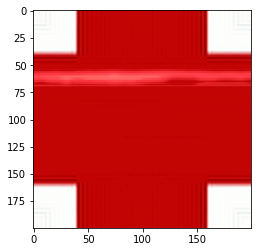

In [221]:
plt.imshow(X)

In [222]:
Changement = np.zeros(Delta_X.shape)

In [223]:
nu = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#for i in range(Delta_X.shape[0]):
#    for j in range(Delta_X.shape[1]):
#        for k in range(Delta_X.shape[2]):
#            if(Delta_X[i,j,k] > 0.0001):
#                Changement[i,j,k] = 1
                
Changement[Delta_X >1e-5] = 1

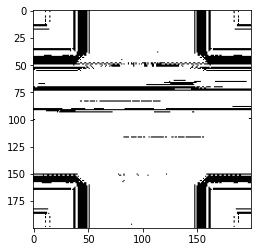

In [224]:
plt.imshow(Changement)

In [194]:
Delta_X

array([[[0.00080284, 0.00080284, 0.00080284],
        [0.00083529, 0.00083529, 0.00083529],
        [0.0008391 , 0.0008391 , 0.0008391 ],
        ...,
        [0.00092155, 0.00092155, 0.00092155],
        [0.00092145, 0.00092145, 0.00092145],
        [0.00092167, 0.00092167, 0.00092167]],

       [[0.00083486, 0.00083486, 0.00083486],
        [0.00083551, 0.00083551, 0.00083551],
        [0.00083933, 0.00083933, 0.00083933],
        ...,
        [0.00092182, 0.00092182, 0.00092182],
        [0.00092162, 0.00092162, 0.00092162],
        [0.00092195, 0.00092195, 0.00092195]],

       [[0.00093246, 0.00093246, 0.00093246],
        [0.0009319 , 0.0009319 , 0.0009319 ],
        [0.00092928, 0.00092928, 0.00092928],
        ...,
        [0.00092138, 0.00092138, 0.00092138],
        [0.00092129, 0.00092129, 0.00092129],
        [0.00092153, 0.00092153, 0.00092153]],

       ...,

       [[0.00092152, 0.00092152, 0.00092152],
        [0.00092131, 0.00092131, 0.00092131],
        [0.00092139, 0